In [41]:
import tensorflow as tf
print(tf.__version__)

2.7.0


In [42]:
!nvidia-smi -L

GPU 0: NVIDIA GeForce GTX 1660 Ti (UUID: GPU-97c4816a-f3d0-3494-8fd1-e9b1c2eaeebd)


In [43]:
from helper_functions import create_tensorboard_callback, plot_loss_curves, compare_historys

In [44]:
import tensorflow_datasets as tfds

In [45]:
datasets_list = tfds.list_builders()
print("food101" in datasets_list)

True


In [46]:
(train_data, test_data), ds_info = tfds.load(name="food101",
                                             split=["train", "validation"], 
                                             shuffle_files=True, 
                                             as_supervised=True,
                                             with_info=True) 

In [47]:
# Features of Food101 TFDS
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=101),
})

In [48]:
# Get class names
class_names = ds_info.features["label"].names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [49]:
# Take one sample off the training data
train_one_sample = train_data.take(1)
train_one_sample

<TakeDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>

In [50]:
# Output info about our training sample
for image, label in train_one_sample:
  print(f"""
  Image shape: {image.shape}
  Image dtype: {image.dtype}
  Target class from Food101 (tensor form): {label}
  Class name (str form): {class_names[label.numpy()]}
        """)


  Image shape: (384, 512, 3)
  Image dtype: <dtype: 'uint8'>
  Target class from Food101 (tensor form): 97
  Class name (str form): takoyaki
        


In [51]:
image

<tf.Tensor: shape=(384, 512, 3), dtype=uint8, numpy=
array([[[ 54,  30,  26],
        [ 57,  33,  29],
        [ 72,  49,  43],
        ...,
        [192, 184, 163],
        [190, 179, 159],
        [181, 169, 147]],

       [[ 51,  28,  22],
        [ 60,  37,  31],
        [ 81,  58,  52],
        ...,
        [191, 183, 162],
        [189, 176, 157],
        [176, 164, 142]],

       [[ 78,  58,  49],
        [ 96,  76,  67],
        [122, 102,  93],
        ...,
        [191, 183, 162],
        [188, 175, 156],
        [172, 157, 136]],

       ...,

       [[162, 140, 117],
        [164, 142, 119],
        [169, 147, 126],
        ...,
        [  5,   5,   5],
        [  6,   6,   6],
        [  6,   6,   6]],

       [[168, 146, 123],
        [170, 148, 125],
        [176, 154, 131],
        ...,
        [  5,   5,   5],
        [  6,   6,   6],
        [  6,   6,   6]],

       [[173, 151, 128],
        [176, 154, 131],
        [182, 160, 137],
        ...,
        [  4,   4,   

In [52]:
tf.reduce_min(image), tf.reduce_max(image)

(<tf.Tensor: shape=(), dtype=uint8, numpy=0>,
 <tf.Tensor: shape=(), dtype=uint8, numpy=255>)

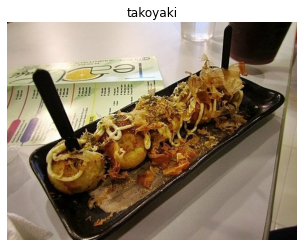

In [53]:
# Plot an image tensor
import matplotlib.pyplot as plt
plt.imshow(image)
plt.title(class_names[label.numpy()])
plt.axis(False);

In [54]:
def preprocess_img(image, label, img_shape=224):
    
  image = tf.image.resize(image, [img_shape, img_shape])
  return tf.cast(image, tf.float32), label 

In [55]:
preprocessed_img = preprocess_img(image, label)[0]
print(f"Image before preprocessing:\n {image[:2]}...,\nShape: {image.shape},\nDatatype: {image.dtype}\n")
print(f"Image after preprocessing:\n {preprocessed_img[:2]}...,\nShape: {preprocessed_img.shape},\nDatatype: {preprocessed_img.dtype}")

Image before preprocessing:
 [[[ 54  30  26]
  [ 57  33  29]
  [ 72  49  43]
  ...
  [192 184 163]
  [190 179 159]
  [181 169 147]]

 [[ 51  28  22]
  [ 60  37  31]
  [ 81  58  52]
  ...
  [191 183 162]
  [189 176 157]
  [176 164 142]]]...,
Shape: (384, 512, 3),
Datatype: <dtype: 'uint8'>

Image after preprocessing:
 [[[ 56.23469   32.591835  27.877552]
  [ 98.16328   75.16328   68.50001 ]
  [121.62245  101.62245   91.63265 ]
  ...
  [191.72456  191.36736  170.93883 ]
  [202.18863  196.9743   176.90286 ]
  [185.918    174.10167  153.6169  ]]

 [[ 93.47959   73.55102   64.19388 ]
  [144.57143  124.64286  113.561226]
  [169.66327  150.20409  138.79082 ]
  ...
  [196.22955  195.22955  176.80103 ]
  [202.02025  194.9335   175.87225 ]
  [182.24942  168.44324  148.72888 ]]]...,
Shape: (224, 224, 3),
Datatype: <dtype: 'float32'>


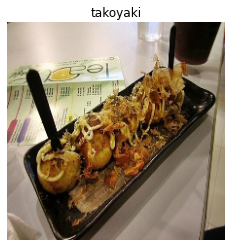

In [56]:
plt.imshow(preprocessed_img/255.)
plt.title(class_names[label])
plt.axis(False);

In [57]:
# Map preprocessing function to training data (and paralellize)
train_data = train_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
# Shuffle train_data and turn it into batches and prefetch it (load it faster)
train_data = train_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

# Map prepreprocessing function to test data
test_data = test_data.map(preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
# Turn test data into batches (don't need to shuffle)
test_data = test_data.batch(32).prefetch(tf.data.AUTOTUNE)

In [58]:
train_data, test_data

(<PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int64)>,
 <PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int64)>)

In [59]:
# Create TensorBoard callback (already have "create_tensorboard_callback()" from a previous notebook)
from helper_functions import create_tensorboard_callback

# Create ModelCheckpoint callback to save model's progress
checkpoint_path = "model_checkpoints/cp.ckpt" 
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      monitor="val_acc",
                                                      save_best_only=True,
                                                      save_weights_only=True, 
                                                      verbose=0)  

In [60]:
# Turn on mixed precision training
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy(policy="mixed_float16")

In [61]:
mixed_precision.global_policy()

<Policy "mixed_float16">

In [63]:
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

# Create base model
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False # freeze base model layers

# Create Functional model 
inputs = layers.Input(shape=input_shape, name="input_layer")
# Note: EfficientNetBX models have rescaling built-in but if your model didn't you could have a layer like below
# x = preprocessing.Rescaling(1./255)(x)
x = base_model(inputs, training=False) # set base_model to inference mode only
x = layers.GlobalAveragePooling2D(name="pooling_layer")(x)
x = layers.Dense(len(class_names))(x) # want one output neuron per class 
# Separate activation of output layer so we can output float32 activations
outputs = layers.Activation("softmax", dtype=tf.float32, name="softmax_float32")(x) 
model = tf.keras.Model(inputs, outputs)

print(f"Outputs dtype: {outputs.dtype.name}")
# Compile the model
model.compile(loss="sparse_categorical_crossentropy", # Use sparse_categorical_crossentropy when labels are *not* one-hot
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

Outputs dtype: float32


In [64]:
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 pooling_layer (GlobalAverag  (None, 1280)             0         
 ePooling2D)                                                     
                                                                 
 dense_2 (Dense)             (None, 101)               129381    
                                                                 
 softmax_float32 (Activation  (None, 101)              0         
 )                                                               
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-train

In [65]:
for layer in model.layers:
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_layer True float32 <Policy "float32">
efficientnetb0 False float32 <Policy "mixed_float16">
pooling_layer True float32 <Policy "mixed_float16">
dense_2 True float32 <Policy "mixed_float16">
softmax_float32 True float32 <Policy "float32">


In [66]:
# Check the layers in the base model and see what dtype policy they're using
for layer in model.layers[1].layers[:20]: # only check the first 20 layers to save output space
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_3 False float32 <Policy "float32">
rescaling_2 False float32 <Policy "mixed_float16">
normalization_2 False float32 <Policy "mixed_float16">
stem_conv_pad False float32 <Policy "mixed_float16">
stem_conv False float32 <Policy "mixed_float16">
stem_bn False float32 <Policy "mixed_float16">
stem_activation False float32 <Policy "mixed_float16">
block1a_dwconv False float32 <Policy "mixed_float16">
block1a_bn False float32 <Policy "mixed_float16">
block1a_activation False float32 <Policy "mixed_float16">
block1a_se_squeeze False float32 <Policy "mixed_float16">
block1a_se_reshape False float32 <Policy "mixed_float16">
block1a_se_reduce False float32 <Policy "mixed_float16">
block1a_se_expand False float32 <Policy "mixed_float16">
block1a_se_excite False float32 <Policy "mixed_float16">
block1a_project_conv False float32 <Policy "mixed_float16">
block1a_project_bn False float32 <Policy "mixed_float16">
block2a_expand_conv False float32 <Policy "mixed_float16">
block2a_expand_bn False

In [67]:
# Fit the model with callbacks
history_101_food_classes_feature_extract = model.fit(train_data, 
                                                     epochs=5,
                                                     steps_per_epoch=len(train_data),
                                                     validation_data=test_data,
                                                     validation_steps=int(0.15 * len(test_data)),
                                                     callbacks=[create_tensorboard_callback("training_logs", 
                                                                                            "efficientnetb0_101_classes_all_data_feature_extract"),
                                                                model_checkpoint])

Saving TensorBoard log files to: training_logs/efficientnetb0_101_classes_all_data_feature_extract/20221108-171100
Epoch 1/5
2367/2368 [============================>.] - ETA: 0s - loss: 1.8224 - accuracy: 0.5568WARNING:tensorflow:Can save best model only with val_acc available, skipping.


2368/2368 [==============================] - 270s 112ms/step - loss: 1.8224 - accuracy: 0.5568 - val_loss: 1.2314 - val_accuracy: 0.6703
Epoch 2/5
2367/2368 [============================>.] - ETA: 0s - loss: 1.2949 - accuracy: 0.6661WARNING:tensorflow:Can save best model only with val_acc available, skipping.


2368/2368 [==============================] - 294s 124ms/step - loss: 1.2949 - accuracy: 0.6661 - val_loss: 1.1230 - val_accuracy: 0.6997
Epoch 3/5
2367/2368 [============================>.] - ETA: 0s - loss: 1.1434 - accuracy: 0.7025WARNING:tensorflow:Can save best model only with val_acc available, skipping.


2368/2368 [==============================] - 295s 124ms/step - loss: 1.1434 - accuracy: 0.7025 - val_loss: 1.0859 - val_accuracy: 0.7066
Epoch 4/5
2367/2368 [============================>.] - ETA: 0s - loss: 1.0447 - accuracy: 0.7271WARNING:tensorflow:Can save best model only with val_acc available, skipping.


2368/2368 [==============================] - 294s 124ms/step - loss: 1.0447 - accuracy: 0.7271 - val_loss: 1.0567 - val_accuracy: 0.7105
Epoch 5/5
2367/2368 [============================>.] - ETA: 0s - loss: 0.9731 - accuracy: 0.7433WARNING:tensorflow:Can save best model only with val_acc available, skipping.


2368/2368 [==============================] - 294s 124ms/step - loss: 0.9731 - accuracy: 0.7433 - val_loss: 1.0590 - val_accuracy: 0.7135


In [68]:
# Evaluate model (unsaved version) on whole test dataset
results_feature_extract_model = model.evaluate(test_data)
results_feature_extract_model

790/790 [==============================] - 75s 94ms/step - loss: 1.0636 - accuracy: 0.7108


[1.0636348724365234, 0.7107722759246826]

In [69]:
save_dir = "efficientnetb0_feature_extract_model_mixed_precision"
model.save(save_dir)

INFO:tensorflow:Assets written to: efficientnetb0_feature_extract_model_mixed_precision\assets


INFO:tensorflow:Assets written to: efficientnetb0_feature_extract_model_mixed_precision\assets
C:\Users\malha\anaconda3\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
C:\Users\malha\anaconda3\lib\site-packages\keras\saving\saved_model\layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


In [70]:
loaded_saved_model = tf.keras.models.load_model(save_dir)

In [71]:
for layer in loaded_saved_model.layers:
  layer.trainable = True
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy) 

input_layer True float32 <Policy "float32">
efficientnetb0 True float32 <Policy "mixed_float16">
pooling_layer True float32 <Policy "mixed_float16">
dense_2 True float32 <Policy "mixed_float16">
softmax_float32 True float32 <Policy "float32">


In [72]:
for layer in loaded_saved_model.layers[1].layers[:20]:
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_3 True float32 <Policy "float32">
rescaling_2 True float32 <Policy "mixed_float16">
normalization_2 True float32 <Policy "mixed_float16">
stem_conv_pad True float32 <Policy "mixed_float16">
stem_conv True float32 <Policy "mixed_float16">
stem_bn True float32 <Policy "mixed_float16">
stem_activation True float32 <Policy "mixed_float16">
block1a_dwconv True float32 <Policy "mixed_float16">
block1a_bn True float32 <Policy "mixed_float16">
block1a_activation True float32 <Policy "mixed_float16">
block1a_se_squeeze True float32 <Policy "mixed_float16">
block1a_se_reshape True float32 <Policy "mixed_float16">
block1a_se_reduce True float32 <Policy "mixed_float16">
block1a_se_expand True float32 <Policy "mixed_float16">
block1a_se_excite True float32 <Policy "mixed_float16">
block1a_project_conv True float32 <Policy "mixed_float16">
block1a_project_bn True float32 <Policy "mixed_float16">
block2a_expand_conv True float32 <Policy "mixed_float16">
block2a_expand_bn True float32 <Policy "m

In [73]:
# Setup EarlyStopping callback to stop training if model's val_loss doesn't improve for 3 epochs
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", # watch the val loss metric
                                                  patience=3) # if val loss decreases for 3 epochs in a row, stop training

# Create ModelCheckpoint callback to save best model during fine-tuning
checkpoint_path = "fine_tune_checkpoints/"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      save_best_only=True,
                                                      monitor="val_loss")

In [74]:
# Creating learning rate reduction callback
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",  
                                                 factor=0.2, # multiply the learning rate by 0.2 (reduce by 5x)
                                                 patience=2,
                                                 verbose=1, # print out when learning rate goes down 
                                                 min_lr=1e-7)

In [75]:
# Compile the model
loaded_saved_model.compile(loss="sparse_categorical_crossentropy", # sparse_categorical_crossentropy for labels that are *not* one-hot
                        optimizer=tf.keras.optimizers.Adam(0.0001), # 10x lower learning rate than the default
                        metrics=["accuracy"])

In [76]:
# Start to fine-tune (all layers)
history_101_food_classes_all_data_fine_tune = loaded_saved_model.fit(train_data,
                                                        epochs=100, 
                                                        steps_per_epoch=len(train_data),
                                                        validation_data=test_data,
                                                        validation_steps=int(0.15 * len(test_data)), 
                                                        callbacks=[create_tensorboard_callback("training_logs", "efficientb0_101_classes_all_data_fine_tuning"),
                                                                   model_checkpoint, 
                                                                   early_stopping, 
                                                                   reduce_lr]) 

Saving TensorBoard log files to: training_logs/efficientb0_101_classes_all_data_fine_tuning/20221108-174136
Epoch 1/100
2368/2368 [==============================] - ETA: 0s - loss: 0.8511 - accuracy: 0.7685INFO:tensorflow:Assets written to: fine_tune_checkpoints\assets


INFO:tensorflow:Assets written to: fine_tune_checkpoints\assets
C:\Users\malha\anaconda3\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


2368/2368 [==============================] - 915s 379ms/step - loss: 0.8511 - accuracy: 0.7685 - val_loss: 0.8091 - val_accuracy: 0.7757 - lr: 1.0000e-04


C:\Users\malha\anaconda3\lib\site-packages\keras\saving\saved_model\layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


Epoch 2/100
2368/2368 [==============================] - 843s 355ms/step - loss: 0.5236 - accuracy: 0.8540 - val_loss: 0.8692 - val_accuracy: 0.7760 - lr: 1.0000e-04
Epoch 3/100
2368/2368 [==============================] - ETA: 0s - loss: 0.2920 - accuracy: 0.9157
Epoch 00003: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
2368/2368 [==============================] - 759s 320ms/step - loss: 0.2920 - accuracy: 0.9157 - val_loss: 0.9372 - val_accuracy: 0.7770 - lr: 1.0000e-04
Epoch 4/100
2368/2368 [==============================] - 754s 318ms/step - loss: 0.0707 - accuracy: 0.9831 - val_loss: 0.9937 - val_accuracy: 0.7979 - lr: 2.0000e-05


In [77]:
loaded_saved_model.save("efficientnetb0_fine_tuned_101_classes_mixed_precision")

INFO:tensorflow:Assets written to: efficientnetb0_fine_tuned_101_classes_mixed_precision\assets


INFO:tensorflow:Assets written to: efficientnetb0_fine_tuned_101_classes_mixed_precision\assets
C:\Users\malha\anaconda3\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
C:\Users\malha\anaconda3\lib\site-packages\keras\saving\saved_model\layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


In [78]:
# Evaluate mixed precision trained loaded model
results_loaded_saved_model_fine_tuned = loaded_saved_model.evaluate(test_data) 
results_loaded_saved_model_fine_tuned

790/790 [==============================] - 72s 91ms/step - loss: 0.9917 - accuracy: 0.79100s - loss: 0.9895 - ac


[0.9916915893554688, 0.7910494804382324]